In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return torch.sin(x) + 0.5*torch.cos(2*x) + 0.25*torch.sin(4*x) + torch.tanh(x) #+ x

# Generate some fake data
X = torch.linspace(-20, 20, 2**12).reshape(-1, 1)
y = f(X)
# add a step function at x = 0
#y[X > 2] += 1.0
#y[X < 2] -= 1.0

X2 = torch.linspace(-20, 20, 2**14).reshape(-1, 1)
y2 = f(X2)


epochs = 10000
lr = 0.01

Epoch 0, Loss: 1.64271104
Epoch 1000, Loss: 0.15496904
Epoch 2000, Loss: 0.01696163
Epoch 3000, Loss: 0.01391928
Epoch 4000, Loss: 0.01038160
Epoch 5000, Loss: 0.00606859
Epoch 6000, Loss: 0.00405473
Epoch 7000, Loss: 0.00051216
Epoch 8000, Loss: 0.00016869
Epoch 9000, Loss: 0.00008288


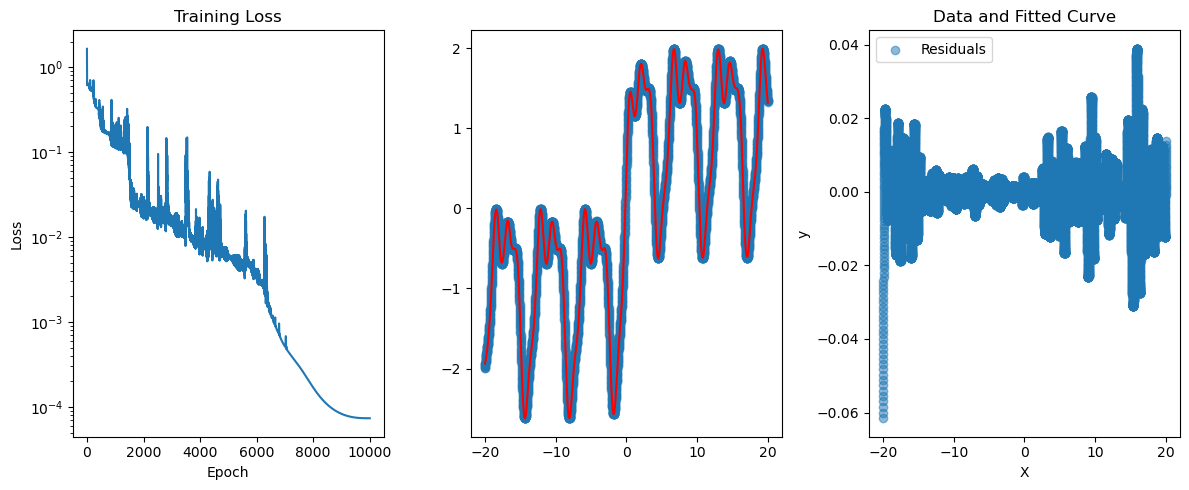

In [2]:

# Define the model
class NonLinearRegression(torch.nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.layer_in = torch.nn.Linear(1, hidden_size)  # input -> first hidden layer
        self.layer_h1 = torch.nn.Linear(hidden_size, hidden_size)  # first -> second hidden layer
        self.layer_h2 = torch.nn.Linear(hidden_size, hidden_size)  # first -> second hidden layer
        self.layer_h3 = torch.nn.Linear(hidden_size, hidden_size)  # first -> second hidden layer
        self.layer_h4 = torch.nn.Linear(hidden_size, hidden_size)  # first -> second hidden layer
        self.layer_out = torch.nn.Linear(hidden_size, 1)   # second hidden layer -> output
        self.tanh = torch.nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.layer_in(x))
        x = self.tanh(self.layer_h1(x))
        x = self.tanh(self.layer_h2(x))
        x = self.tanh(self.layer_h3(x))
        x = self.tanh(self.layer_h4(x))
        x = self.layer_out(x)
        return x

# Create model, loss function, and optimizer
model = NonLinearRegression(hidden_size=32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam works better than SGD for this
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)

# Training loop
losses = []
for epoch in range(epochs):  # more epochs for more complex function
    # Forward pass
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.8f}')

# Plot the results
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')  # log scale makes it easier to see the progress

# Plot the data and fitted curve
plt.subplot(1, 3, 2)
plt.scatter(X.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(X.numpy(), model(X).detach().numpy(), 'r', label='Fitted Curve')

# plot the difference between the data and the model
plt.subplot(1, 3, 3)
plt.scatter(X2.numpy(), (y2 - model(X2).detach()).numpy(), label='Residuals', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data and Fitted Curve')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0, Loss: 1.64193082
Epoch 1000, Loss: 0.00001282
Epoch 2000, Loss: 0.00000522
Epoch 3000, Loss: 0.00005727
Epoch 4000, Loss: 0.00000576
Epoch 5000, Loss: 0.00000135
Epoch 6000, Loss: 0.00000059
Epoch 7000, Loss: 0.00000037
Epoch 8000, Loss: 0.00000027
Epoch 9000, Loss: 0.00000023


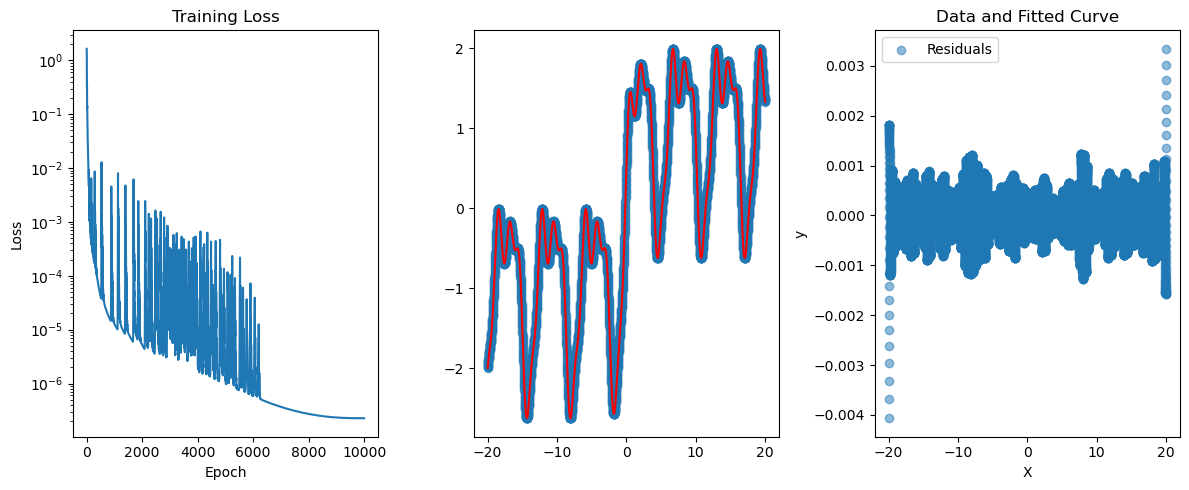

In [3]:
# Define the model
class FourierModelRegression(torch.nn.Module):
    def __init__(self, num_hidden=16, num_fourier=16, x_min=-20, x_max=20):
        """
        Given an input x (B,1) this model first computes a new fourier representation of size
        (B, fourier_terms). This is then passed through a series of hidden layers to produce the output.
        This method AUGHT to be at least as expressive as the spectral method with the same number of 
        fourier terms.

        Args:
            hidden_size (int): size of the hidden layers
            fourier_terms (int): number of fourier terms to use
            x_min (float): minimum value on the domain of x
            x_max (float): maximum value on the domain of x
        """
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        self.num_hidden = num_hidden
        self.num_fourier = num_fourier
        assert self.num_fourier % 2 == 0, "num_fourier must be even"

        d = x_max - x_min
        k0 = np.pi / d
        fourier_terms = [k0 * i for i in range(num_fourier//2)]
        self.fourier_terms = torch.tensor(fourier_terms, dtype=torch.float32)
        # print(f"Fourier terms: {self.fourier_terms}")

        self.layer_in = torch.nn.Linear(num_fourier, num_hidden)  # input -> first hidden layer
        self.layer_h1 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h2 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h3 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h4 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_out = torch.nn.Linear(num_hidden, 1)   # second hidden layer -> output
        self.tanh = torch.nn.Tanh()
    
    def forward(self, x):

        kx = (x - self.x_min) * self.fourier_terms
        kx = torch.cat([torch.sin(kx), torch.cos(kx)], dim=1)
        # instead of having the first term in kx being sin(k0*x) with k0 = 0, we overwrite it with x
        #kx[:, 0] = x[:, 0]  # this is the first term in the fourier series

        # print(f"x shape: {x.shape}")
        # print(f"kx shape: {kx.shape}")
        # print(f"fourier terms shape: {self.fourier_terms.shape}")
        # print(f"kx: {kx}")
        # print(f"x: {x}")
        

        x = self.tanh(self.layer_in(kx))
        x = self.tanh(self.layer_h1(x))
        x = self.tanh(self.layer_h2(x))
        x = self.tanh(self.layer_h3(x))
        x = self.tanh(self.layer_h4(x))
        x = self.layer_out(x)
        return x
    
# Create model, loss function, and optimizer
model = FourierModelRegression(num_hidden=16, num_fourier=64, x_min=-20, x_max=20)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam works better than SGD for this
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)

# Training loop
losses = []
for epoch in range(epochs):  # more epochs for more complex function
    # Forward pass
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.8f}')

# Plot the results
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')  # log scale makes it easier to see the progress

# Plot the data and fitted curve
plt.subplot(1, 3, 2)
plt.scatter(X.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(X.numpy(), model(X).detach().numpy(), 'r', label='Fitted Curve')

# plot the difference between the data and the model
plt.subplot(1, 3, 3)
plt.scatter(X2.numpy(), (y2 - model(X2).detach()).numpy(), label='Residuals', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data and Fitted Curve')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0, Loss: 47.45725250
Epoch 1000, Loss: 0.00000486
Epoch 2000, Loss: 0.00004569
Epoch 3000, Loss: 0.00000829
Epoch 4000, Loss: 0.00002362
Epoch 5000, Loss: 0.00000069
Epoch 6000, Loss: 0.00000019
Epoch 7000, Loss: 0.00000008
Epoch 8000, Loss: 0.00000005
Epoch 9000, Loss: 0.00000005


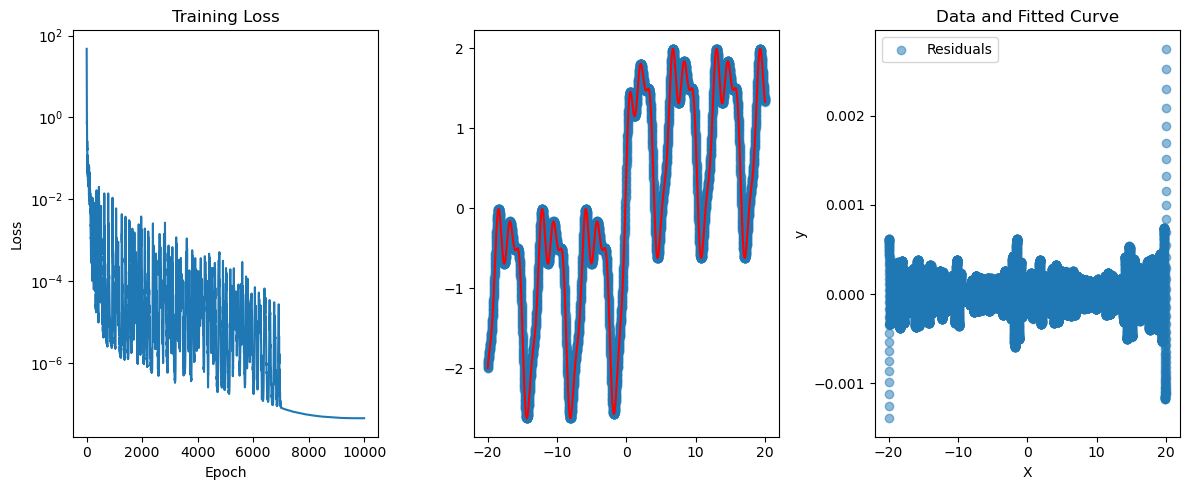

In [4]:
# Define the model
class FourierBasisModelRegression(torch.nn.Module):
    def __init__(self, num_hidden=16, num_fourier=16, x_min=-20, x_max=20, p_dropout=0.0):
        """
        Given an input x (B,1) this model first computes a new fourier representation of size
        (B, fourier_terms). This is then passed through a series of hidden layers to produce the output.
        This method AUGHT to be at least as expressive as the spectral method with the same number of 
        fourier terms.

        Args:
            hidden_size (int): size of the hidden layers
            fourier_terms (int): number of fourier terms to use
            x_min (float): minimum value on the domain of x
            x_max (float): maximum value on the domain of x
        """
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        self.num_hidden = num_hidden
        self.num_fourier = num_fourier
        assert self.num_fourier % 2 == 0, "num_fourier must be even"

        d = x_max - x_min
        k0 = np.pi / d
        fourier_terms = [k0 * i for i in range(num_fourier//2)]
        self.fourier_terms = torch.tensor(fourier_terms, dtype=torch.float32)
        # print(f"Fourier terms: {self.fourier_terms}")

        self.layer_in = torch.nn.Linear(num_fourier, num_hidden)  # input -> first hidden layer
        self.layer_h1 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h2 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h3 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_h4 = torch.nn.Linear(num_hidden, num_hidden)  # first -> second hidden layer
        self.layer_out = torch.nn.Linear(num_hidden, num_fourier)   # second hidden layer -> output

        self.tanh = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(p_dropout)
        self.norm_in = torch.nn.LayerNorm(num_hidden)
        self.norm_h1 = torch.nn.LayerNorm(num_hidden)
        self.norm_h2 = torch.nn.LayerNorm(num_hidden)
        self.norm_h3 = torch.nn.LayerNorm(num_hidden)
        self.norm_h4 = torch.nn.LayerNorm(num_hidden)
    
    def forward(self, x):

        # kx = (x - self.x_min) * self.fourier_terms
        # kx = torch.cat([torch.sin(kx), torch.cos(kx)], dim=1)
        # # instead of having the first term in kx being sin(k0*x) with k0 = 0, we overwrite it with x
        # #kx[:, 0] = x[:, 0]  # this is the first term in the fourier series

        # # print(f"x shape: {x.shape}")
        # # print(f"kx shape: {kx.shape}")
        # # print(f"fourier terms shape: {self.fourier_terms.shape}")
        # # print(f"kx: {kx}")
        # # print(f"x: {x}")
        

        # x = self.tanh(self.layer_in(kx))
        # x = x+self.tanh(self.layer_h1(x))
        # x = x+self.tanh(self.layer_h2(x))
        # x = x+self.tanh(self.layer_h3(x))
        # x = x+self.tanh(self.layer_h4(x)) # (B, num_hidden)
        # x = self.layer_out(x) # (B, num_fourier)
        # x = x*kx # (B, num_fourier)
        # x = torch.sum(x, dim=1, keepdim=True) # (B, 1)
        # return x
        
        # Compute Fourier features
        kx = (x - self.x_min) * self.fourier_terms
        kx = torch.cat([torch.sin(kx), torch.cos(kx)], dim=1)  # (B, num_fourier)

        # Input layer
        x = self.tanh(self.layer_in(kx))
        x = self.norm_in(x)
        #x = self.dropout(x)

        # Hidden layers with residual connections
        residual = x
        x = self.tanh(self.layer_h1(x))
        x = self.norm_h1(x)
        #x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.tanh(self.layer_h2(x))
        x = self.norm_h2(x)
        #x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.tanh(self.layer_h3(x))
        x = self.norm_h3(x)
        #x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.tanh(self.layer_h4(x))
        x = self.norm_h4(x)
        #x = self.dropout(x)
        x = x + residual

        # Output layer (no dropout here)
        x = self.layer_out(x)  # (B, num_fourier)
        
        # Weighted sum
        x = x * kx  # (B, num_fourier)
        x = torch.sum(x, dim=1, keepdim=True)  # (B, 1)
        return x
    
# Create model, loss function, and optimizer
model = FourierBasisModelRegression(num_hidden=24, num_fourier=64, x_min=-20, x_max=20, p_dropout=0.0)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Adam works better than SGD for this
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)

# Training loop
losses = []
model.train()
for epoch in range(epochs):  # more epochs for more complex function
    # Forward pass
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.8f}')


model.eval()
# Plot the results
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')  # log scale makes it easier to see the progress

# Plot the data and fitted curve
plt.subplot(1, 3, 2)
plt.scatter(X.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(X.numpy(), model(X).detach().numpy(), 'r', label='Fitted Curve')

# plot the difference between the data and the model
plt.subplot(1, 3, 3)
plt.scatter(X2.numpy(), (y2 - model(X2).detach()).numpy(), label='Residuals', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data and Fitted Curve')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0, Loss: 96.23562622
Epoch 1000, Loss: 0.00064845
Epoch 2000, Loss: 0.00000101
Epoch 3000, Loss: 0.00000035
Epoch 4000, Loss: 0.00000056
Epoch 5000, Loss: 0.00000008
Epoch 6000, Loss: 0.00002276
Epoch 7000, Loss: 0.00002825
Epoch 8000, Loss: 0.00000001
Epoch 9000, Loss: 0.00000001


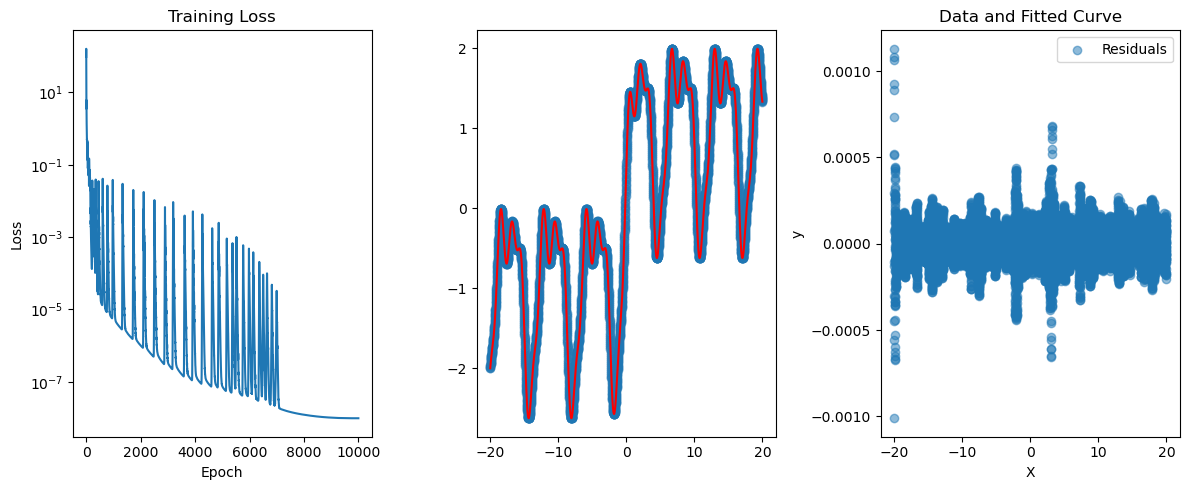

In [102]:
# Define the model
class FourierBasisModel(torch.nn.Module):
    def __init__(self, num_hidden=16, num_fourier=16, x_min=-20, x_max=20, p_dropout=0.0):
        """
        Given an input x (B,1) this model first computes a positional encoding in terms of
        fourier features.

        Args:
            hidden_size (int): size of the hidden layers
            fourier_terms (int): number of fourier terms to use
            x_min (float): minimum value on the domain of x
            x_max (float): maximum value on the domain of x
        """
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        self.num_hidden = num_hidden
        self.num_fourier = num_fourier
        assert self.num_fourier % 2 == 0, "num_fourier must be even"

        d = x_max - x_min
        k0 = np.pi / d
        fourier_terms = [k0 * i for i in range(num_fourier//2)]
        self.fourier_terms = torch.tensor(fourier_terms, dtype=torch.float32)
        # print(f"Fourier terms: {self.fourier_terms}")

        self.layer_in = torch.nn.Linear(num_fourier, num_hidden)  # input -> first hidden layer
        self.layers = torch.nn.ModuleList()
        for i in range(4):
            self.layers.append(torch.nn.Linear(num_hidden, num_hidden))
        self.layer_out = torch.nn.Linear(num_hidden, num_fourier)   # second hidden layer -> output

        self.layer_norm = torch.nn.LayerNorm(num_hidden)
        self.activation = torch.nn.Tanh()
    
    def forward(self, x):
        
        # Compute Fourier features
        kx = (x - self.x_min) * self.fourier_terms # (B, num_fourier//2)
        kx = torch.cat([torch.sin(kx), torch.cos(kx)], dim=1)  # (B, num_fourier)

        # Input layer
        y = self.layer_norm(self.activation(self.layer_in(kx))) # (B, num_hidden)

        # Hidden layers with residual connections
        # for layer in self.layers:
        #     y = y + self.layer_norm(self.activation(layer(y)))

        # Output layer (no dropout here)
        y = self.layer_out(y)  # (B, num_fourier)
        
        # dot product with fourier features
        y = torch.sum(y*kx, dim=1, keepdim=True)  # (B, 1)
        return y
    
# Create model, loss function, and optimizer
model = FourierBasisModel(num_hidden=32, num_fourier=512, x_min=-20, x_max=20, p_dropout=0.0)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Adam works better than SGD for this
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)

# Training loop
losses = []
model.train()
for epoch in range(epochs):  # more epochs for more complex function
    # Forward pass
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.8f}')


model.eval()
# Plot the results
plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')  # log scale makes it easier to see the progress

# Plot the data and fitted curve
plt.subplot(1, 3, 2)
plt.scatter(X.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(X.numpy(), model(X).detach().numpy(), 'r', label='Fitted Curve')

# plot the difference between the data and the model
plt.subplot(1, 3, 3)
plt.scatter(X2.numpy(), (y2 - model(X2).detach()).numpy(), label='Residuals', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Data and Fitted Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 4, 4:   0.02118571
# 4, 8:   0.00113759
# 4, 16:  0.00061406
# 4, 32:  0.00001602
# 4, 64:  0.00000228
# 4, 128: 0.00000008

# 8, 4:   0.00130320
# 8, 8:   0.00005984
# 8, 16:  0.00000387
# 8, 32:  0.00000084
# 8, 64:  0.00000007
# 8, 128: 0.00000004

# 16, 4:   0.00005001
# 16, 8:   0.00001116
# 16, 16:  0.00000162
# 16, 32:  0.00000034
# 16, 64:  0.00000007
# 16, 128: 0.00000002

# 32, 4:   0.00004969
# 32, 8:   0.00000868
# 32, 16:  0.00000150
# 32, 32:  0.00000022
# 32, 64:  0.00000003
# 32, 128: 0.00000001

# 64, 4:   0.00003264
# 64, 8:   0.00000392
# 64, 16:  0.00000111
# 64, 32:  0.00000040
# 64, 64:  0.00000011
# 64, 128: 0.00000001

# without the hidden layers (e.g. x -> fourier -> tanh(num_hidden) -> fourier -> sum):
# what this is showing is that a normal fourier transform with 128-256 terms IS a good approximator, whereas 64 and below is not
# NEED to check this explicitly with the actual fourier transform.
# 1, 4:    0.86706114
# 1, 8:    0.74711800
# 1, 16:   0.62872922
# 1, 32:   0.14143604
# 1, 64:   0.02967647
# 1, 128:  0.00000132 # clear drop at 128
# 1, 256:  0.00000021
# 1, 512:  0.00000057

# 2, 4:    0.86706048
# 2, 8:    0.63621438 # clearly seeing two different regions
# 2, 16:   0.17275354
# 2, 32:   0.02917068
# 2, 64:   0.01341328
# 2, 128:  0.00000063 # clear drop at 128
# 2, 256:  0.00000033
# 2, 512:  0.00000043

# 4, 4:    0.47996837
# 4, 8:    0.05159501
# 4, 16:   0.00595586
# 4, 32:   0.00004801 # clear drop (at 32, not 128)
# 4, 64:   0.00000064
# 4, 128:  0.00000009
# 4, 256:  0.00000011
# 4, 512:  0.00000017

# 8, 4:    0.11860353
# 8, 8:    0.01713393
# 8, 16:   0.00007195 # clear drop (at 16 , not 32)
# 8, 32:   0.00000590
# 8, 64:   0.00000015
# 8, 128:  0.00000005
# 8, 256:  0.00000006
# 8, 512:  0.00000006

# 16, 4:   0.13212448
# 16, 8:   0.01262862
# 16, 16:  0.00006628 
# 16, 32:  0.00000265
# 16, 64:  0.00000009
# 16, 128: 0.00000004
# 16, 256: 0.00000003
# 16, 512: 0.00000003

# 32, 4:   0.29102069
# 32, 8:   0.02751246
# 32, 16:  0.00005388 # clear drop (at 16, not 32)
# 32, 32:  0.00000297
# 32, 64:  0.00000005
# 32, 128: 0.00000001
# 32, 256: 0.00000001
# 32, 512: 0.00000001